In [201]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.layers import Add


In [202]:
MODEL_NAME = 'vgg16'  # 'vgg16' or 'resnet50'
INPUT_SHAPE = (224, 224, 3)
NUM_SAMPLES = 100
TARGET_POSITION = (14, 14)  # (h, w) center of last feature map
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [203]:
class NoResidualAdd(Add):
	def call(self, inputs, **kwargs):
		# Return only the convolutional path, ignore the shortcut
		return inputs[1]

# Replace all Add layers with NoResidualAdd
def strip_residuals(model):
	for i, layer in enumerate(model.layers):
		if isinstance(layer, Add):
			config = layer.get_config()
			name = config["name"]
			new_layer = NoResidualAdd(name=name)
			model.layers[i] = new_layer
	return model


def get_model_and_layer(model_name):
	if model_name == 'vgg16':
		model = VGG16(weights=None, include_top=False, input_shape=INPUT_SHAPE)
		target_layer = model.get_layer('block4_conv1')
		print(target_layer.output_shape)
		TARGET_POSITION = (target_layer.output_shape[1]//2, target_layer.output_shape[2]//2)
		preprocess = preprocess_vgg
	elif model_name == 'resnet50':
		model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
		model = strip_residuals(model)
		for layer in model.layers:
			if isinstance(layer, Add):
				print("Still contains residual connections.")
		target_layer = model.get_layer('conv5_block3_3_conv')
		TARGET_POSITION = (target_layer.output_shape[1]//2, target_layer.output_shape[2]//2)
		preprocess = preprocess_resnet
	else:
		raise ValueError("Unsupported model")

	# Create a model that outputs the target layer
	submodel = tf.keras.Model(inputs=model.input, outputs=target_layer.output)
	return submodel, preprocess, TARGET_POSITION

model, preprocess_fn, TARGET_POSITION = get_model_and_layer(MODEL_NAME)

(None, 28, 28, 512)


In [204]:
model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [209]:
def compute_erf(model, preprocess_fn, num_samples=10, target_pos=(14,14)):
	grads_accum = np.zeros(INPUT_SHAPE[:2], dtype=np.float32)

	for i in range(num_samples):
		img = np.random.uniform(low=0, high=255, size=(1, *INPUT_SHAPE)).astype(np.int32)
		img_pp = preprocess_fn(img.copy())
		img_pp = tf.convert_to_tensor(img_pp)
		with tf.GradientTape() as tape:
			tape.watch(img_pp)
			feature_maps = model(img_pp, training=False)
			y = feature_maps[0, target_pos[0],  target_pos[1], 475]

			#scalar = tf.reduce_sum(y)
			#print(scalar)

		grads = tape.gradient(y, img_pp)[0]
		squared_grad = tf.square(grads)
		grads_accum += tf.reduce_sum(squared_grad, axis=-1).numpy()

	erf = grads_accum / num_samples
	#erf = tf.nn.relu(erf)
	return erf

erf_map = compute_erf(model, preprocess_fn, NUM_SAMPLES, TARGET_POSITION)


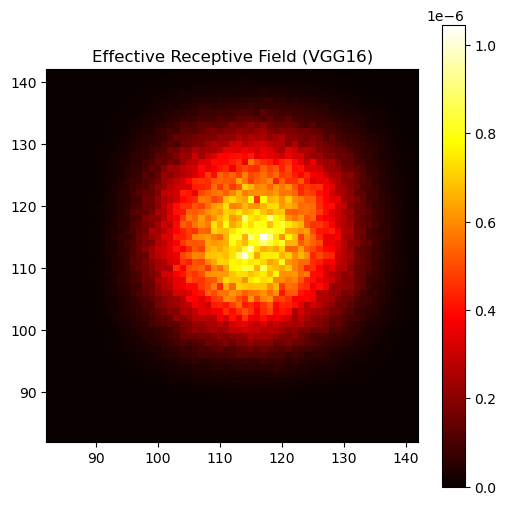

In [213]:
plt.figure(figsize=(6, 6))
plt.imshow(erf_map, cmap='hot')

S = 30
x_min, x_max = INPUT_SHAPE[0]//2 - S , INPUT_SHAPE[1]//2 + S
y_min, y_max =INPUT_SHAPE[0]//2 - S , INPUT_SHAPE[1]//2 + S

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.colorbar()
plt.title(f'Effective Receptive Field ({MODEL_NAME.upper()})')
plt.show()